# 0.0. IMPORTS

## 0.1. Bibliotecas

In [186]:
import pandas as pd
import numpy as np
import os
import math

from unidecode import unidecode

import matplotlib.pyplot as plt

## 0.2. Carregar Dados

### 0.2.1. Escolas

In [187]:
diretorio_escolas = os.path.dirname(os.path.abspath('escolas.csv'))
caminho_escolas = os.path.join(diretorio_escolas, '../..', 'data', 'raw', 'escolas.csv')
df_escolas_raw = pd.read_csv(caminho_escolas)

### 0.2.2. Material Didatico

In [188]:
diretorio_material_didatico = os.path.dirname(os.path.abspath('material_didatico.csv'))
caminho_material_didatico = os.path.join(diretorio_material_didatico, '../..', 'data', 'raw', 'material_didatico.csv')
df_material_didatico_raw = pd.read_csv(caminho_material_didatico)

### 0.2.3. Sub-Prefeituras

In [189]:
diretorio_subprefeituras = os.path.dirname(os.path.abspath('subprefeituras.csv'))
caminho_subprefeituras = os.path.join(diretorio_subprefeituras, '../..', 'data', 'raw', 'subprefeituras.csv')
df_subprefeituras_raw = pd.read_csv(caminho_subprefeituras)

## 0.3. Funções

### 0.3.1. renomeia_colunas

In [190]:
def renomeia_colunas(data):
    return [x.lower().rstrip() for x in data.columns]

### 0.3.2. tamanho_dos_dados

In [191]:
def tamanho_dos_dados(data):
    print(f'Colunas: {data.shape[1]}')
    print(f'Linhas: {data.shape[0]}')

### 0.3.3. qtd_total_unicos_por_coluna

In [192]:
def qtd_total_unicos_por_coluna(data):
    for x in data.columns:
        print(f'Quantidade de valores unicos em {x}: {len(data[x].unique())}')

### 0.3.4. get_numericos

In [193]:
def get_numericos(data):
    return data.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

### 0.3.5. get_categoricos

In [194]:
def get_categoricos(data):
    return data.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

### 0.3.6. get_descriptive_info

In [195]:
def get_descriptive_info(data):
    dados_numericos = get_numericos(data)
    
    # medidas de tendencia central - media, mediana
    df_media = pd.DataFrame(dados_numericos.apply(np.mean)).T
    df_mediana = pd.DataFrame(dados_numericos.apply(np.median)).T   
    
    # medidas de dispersão - min, max, range, skew, kurtosis, std
    df_std = pd.DataFrame(dados_numericos.apply(np.std)).T
    df_min = pd.DataFrame(dados_numericos.apply(min)).T
    df_max = pd.DataFrame(dados_numericos.apply(max)).T
    df_range = pd.DataFrame(dados_numericos.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(dados_numericos.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(dados_numericos.apply(lambda x: x.kurtosis())).T
    
    #min, max, range, media, mediana, std, skew, kurtosis
    df_descriptive_info = pd.concat([df_min, df_max, df_range,
                                     df_media, df_mediana, df_std,
                                     df_skew, df_kurtosis]).T.reset_index()
    
    df_descriptive_info.columns = ['attributes', 'min', 'max',
                                   'range', 'media', 'mediana',
                                   'std', 'skew', 'kurtosis']
    
    return df_descriptive_info

### 0.3.7. salvar_dados_csv

In [196]:
def salvar_dados_csv(data, nome=''):
    data.to_csv(f'../../data/processed/{nome}', index=False )

### 0.3.8. remove_acentos

In [197]:
def remove_acentos(data):
    categoricos = get_categoricos(data)
    for column in categoricos.columns:        
        data[column] = data[column].apply(lambda x: unidecode(x))
    return data

### 0.3.9. string_maisculo

In [198]:
def string_maisculo(data):
    categoricos = get_categoricos(data)

    for column in categoricos:
        data[column] = data[column].str.upper()
        
    return data

### 0.3.10. remodelando_id

In [110]:
def remodelando_id(data):
    data['id'] = data['id'].astype(str).apply(lambda x: f'0{x}' if len(x) < 3 else f'{x}')
    return data

### 0.3.11. distance

In [111]:
def distance(point1, point2):
    """
    Calcula a distância entre dois pontos geográficos, usando a fórmula de Haversine.
    """
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # raio da Terra em quilômetros
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = (
        math.sin(delta_phi / 2) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d

### 0.3.12. nearest_neighbor

In [112]:
def nearest_neighbor(points):
    unvisited = set(
        range(1, len(points))
    )  # índices que representam os pontos não visitados
    current_point = 0
    route = [current_point]

    while unvisited:
        nearest = min(
            unvisited, key=lambda x: distance(points[current_point], points[x])
        )
        route.append(nearest)
        unvisited.remove(nearest)
        current_point = nearest

    route.append(0)  # Volta ao ponto inicial para fechar o ciclo
    return route

### 0.3.13. extrair_tipo_escola

In [113]:
def extrair_tipo_escola(texto):
    partes = texto.split()  
    return partes[0]  

### 0.3.14. extrair_nome_escola

In [114]:
def extrair_nome_escola(texto):
    indice_primeiro_espaco = texto.find(' ')  
    if indice_primeiro_espaco != -1:
        return texto[indice_primeiro_espaco+1:]
    else:
        return texto

### 0.3.15. extrair_numero

In [115]:
def extrair_numero(endereco):
    palavras = endereco.split()
    for palavra in palavras:
        if palavra.isdigit():
            return palavra
    return '9999'

# 1.0. DESCRIÇÃO DOS DADOS

## 1.1. Escolas

### 1.1.1. Visão Geral dos Dados

In [199]:
df1_escolas = df_escolas_raw.copy()

In [200]:
df1_escolas.head().T

,0,1,2,3,4
id,178,634,483,476,132
Escolas_Postos,CENTRO INTEGRADO DE EDUCAÇÃO PÚBLICA HENFIL,EM ALICE DO AMARAL PEIXOTO,EM CELESTINO SILVA,ESCOLA MUNICIPAL FLORIANO PEIXOTO,EM PEREIRA PASSOS
BAIRRO,CAJU,BENFICA,CENTRO,SÃO CRISTÓVÃO,RIO COMPRIDO
ENDEREÇO,Rua Carlos Seidl S/Nº,Rua Ébano 187,"R. do Lavradio, 56",Praça Argentina 20,Praça Condessa Paulo de Frontin 45
lat,"-22,880888","-22,889574","-22,909293","-22,897629","-22,924412"
lon,"-43,225326","-43,236202","-43,183579","-43,227456","-43,208579"


In [201]:
df1_escolas.columns = renomeia_colunas(df1_escolas)

In [202]:
df1_escolas.columns

Index(['id', 'escolas_postos', 'bairro', 'endereço', 'lat', 'lon'], dtype='object')

### 1.1.2. Tamanho dos dados

In [120]:
tamanho_dos_dados(df1_escolas)

Colunas: 6
Linhas: 152


In [203]:
qtd_total_unicos_por_coluna(df1_escolas)

Quantidade de valores unicos em id: 136
Quantidade de valores unicos em escolas_postos: 136
Quantidade de valores unicos em bairro: 90
Quantidade de valores unicos em endereço: 137
Quantidade de valores unicos em lat: 136
Quantidade de valores unicos em lon: 135


### 1.1.3. Verificar Nulos

In [204]:
df1_escolas.isna().sum()

id                0
escolas_postos    0
bairro            0
endereço          0
lat               0
lon               0
dtype: int64

### 1.1.4. Verificar tipos dos dados

In [205]:
df1_escolas.dtypes

id                 int64
escolas_postos    object
bairro            object
endereço          object
lat               object
lon               object
dtype: object

### 1.1.5. Verificar dados duplicados

In [206]:
df1_escolas.duplicated().sum()

13

### 1.1.6. Tratamento Inicial

In [207]:
df1_escolas = df1_escolas.drop_duplicates()

In [208]:
df1_escolas

,id,escolas_postos,bairro,endereço,lat,lon
0,178,CENTRO INTEGRADO DE EDUCAÇÃO PÚBLICA HENFIL,CAJU,Rua Carlos Seidl S/Nº,"-22,880888","-43,225326"
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,Rua Ébano 187,"-22,889574","-43,236202"
2,483,EM CELESTINO SILVA,CENTRO,"R. do Lavradio, 56","-22,909293","-43,183579"
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SÃO CRISTÓVÃO,Praça Argentina 20,"-22,897629","-43,227456"
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,Praça Condessa Paulo de Frontin 45,"-22,924412","-43,208579"
...,...,...,...,...,...,...
146,210,EM DEBORA MENDES DE MORAES,PEDRA DE GUARATIBA,Rua Belchior Da Fonseca 643,"-23,001416","-43,638757"
147,474,EM ENGENHEIRO GASTÃO RANGEL,GUARATIBA,Estrada Do Magarça 9.183,"-22,98046","-43,643545"
148,301,EM JONATAS SERRANO,GUARATIBA,"Estrada Do Mato Alto, S/Nº","-22,953163","-43,577409"
149,215,E.M. NARCISA AMALIA,ILHA DE GUARATIBA,Estrada Teodoreto de Camargo S/N.º,"-23,009084","-43,537582"


In [209]:
df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("R.", "Rua")

C:\Users\Lavinia\AppData\Local\Temp\ipykernel_9000\4095934012.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df1_escolas['endereço'] = df1_escolas['endereço'].str.replace("R.", "Rua")


In [210]:
df1_escolas['lat'] = df1_escolas['lat'].str.replace(',', '.')
df1_escolas['lat'] = pd.to_numeric(df1_escolas['lat']).round(5)

df1_escolas['lon'] = df1_escolas['lon'].str.replace(',', '.')
df1_escolas['lon'] = pd.to_numeric(df1_escolas['lon']).round(5)

df1_escolas.dtypes

id                  int64
escolas_postos     object
bairro             object
endereço           object
lat               float64
lon               float64
dtype: object

In [211]:
df1_escolas = remove_acentos(df1_escolas)

In [212]:
df1_escolas = remodelando_id(df1_escolas)

In [131]:
df1_escolas = string_maisculo(df1_escolas)

In [213]:
tamanho_dos_dados(df1_escolas)

Colunas: 6
Linhas: 139


### 1.1.6. Salvar dados

In [214]:
salvar_dados_csv(df1_escolas, 'df1_escolas_descricao_dados.csv')

## 1.2. Material Didatico

### 1.2.1. Visão Geral dos Dados

In [134]:
df1_material_didatico = df_material_didatico_raw.copy()

In [135]:
df1_material_didatico.head().T

,0,1,2,3,4
id,178,634,483,476,132
Quantidade,20,121,220,190,67


In [136]:
df1_material_didatico.columns = renomeia_colunas(df1_material_didatico)

### 1.2.2. Tamanho dos dados

In [137]:
tamanho_dos_dados(df1_material_didatico)

Colunas: 2
Linhas: 151


In [138]:
qtd_total_unicos_por_coluna(df1_material_didatico)

Quantidade de valores unicos em id: 151
Quantidade de valores unicos em quantidade: 135


### 1.2.3. Verificar Nulos

In [139]:
df1_material_didatico.isna().sum()

id            0
quantidade    4
dtype: int64

### 1.2.4. Verificar tipos dos dados

In [140]:
df1_material_didatico.dtypes

id             int64
quantidade    object
dtype: object

### 1.2.5. Verificar dados duplicados

In [141]:
df1_material_didatico.duplicated().sum()

0

### 1.2.6. Tratamento Inicial

In [142]:
df1_material_didatico['quantidade'].unique()

array(['20', '121', '220', '190', '67', '397', '92', '578', '591', '473',
       '456', '223', '420', '573', "''", '366', '516', '319', '308',
       '111', '48', '525', '445', '164', '293', '152', '399', '185',
       '576', '63', '491', "'NaN'", '336', '159', '342', '262', '440',
       '365', nan, '183', '297', '44', '109', '350', '255', '457', '493',
       '489', '64', '530', '158', '123', '468', '234', '24', '218', '151',
       '564', '504', '61', '426', '167', '509', '292', '210', '153',
       "'397'", '41', '561', '180', '257', '260', '317', '345', '32',
       '513', '338', '416', '352', '393', '425', '136', "'395'", '115',
       '534', '430', '466', '51', '26', '94', '128', '520', '524', '279',
       '161', '179', '194', '599', '315', '435', '400', '294', '148',
       '269', '571', '235', '187', '392', '362', '71', '221', '372',
       '479', '99', '157', '296', '330', '316', '106', '207', '459',
       '537', '162', '579', '517', "' '", '135', '118', '341', '329',
     

In [143]:
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].str.replace("'", "")
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].replace(" ", np.nan)
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].replace('NaN', np.nan)

# Converter a coluna 'quantidade' para tipo numérico
df1_material_didatico['quantidade'] = pd.to_numeric(df1_material_didatico['quantidade'])

moda = df1_material_didatico['quantidade'].value_counts().idxmax()
df1_material_didatico['quantidade'] = df1_material_didatico['quantidade'].fillna(moda)


# Verificar se as correções foram aplicadas corretamente
print(df1_material_didatico['quantidade'].unique())


[ 20. 121. 220. 190.  67. 397.  92. 578. 591. 473. 456. 223. 420. 573.
 342. 366. 516. 319. 308. 111.  48. 525. 445. 164. 293. 152. 399. 185.
 576.  63. 491. 336. 159. 262. 440. 365. 183. 297.  44. 109. 350. 255.
 457. 493. 489.  64. 530. 158. 123. 468. 234.  24. 218. 151. 564. 504.
  61. 426. 167. 509. 292. 210. 153.  41. 561. 180. 257. 260. 317. 345.
  32. 513. 338. 416. 352. 393. 425. 136. 395. 115. 534. 430. 466.  51.
  26.  94. 128. 520. 524. 279. 161. 179. 194. 599. 315. 435. 400. 294.
 148. 269. 571. 235. 187. 392. 362.  71. 221. 372. 479.  99. 157. 296.
 330. 316. 106. 207. 459. 537. 162. 579. 517. 135. 118. 341. 329. 570.
 320. 335. 521. 225.]


In [144]:
df1_material_didatico = remodelando_id(df1_material_didatico)
df1_material_didatico['id'].unique()

array(['178', '634', '483', '476', '132', '410', '055', '490', '600',
       '089', '387', '331', '450', '558', '413', '698', '540', '309',
       '268', '523', '017', '035', '011', '226', '638', '271', '126',
       '180', '163', '361', '280', '060', '587', '653', '660', '382',
       '217', '378', '429', '025', '367', '373', '624', '157', '020',
       '117', '502', '351', '135', '647', '440', '259', '422', '041',
       '537', '230', '683', '146', '566', '388', '498', '663', '121',
       '161', '263', '118', '140', '260', '236', '090', '274', '676',
       '390', '608', '589', '256', '091', '285', '248', '441', '623',
       '603', '673', '182', '520', '412', '031', '514', '023', '415',
       '016', '570', '528', '414', '690', '202', '550', '211', '526',
       '492', '466', '636', '527', '586', '080', '398', '175', '308',
       '512', '576', '495', '379', '641', '689', '171', '477', '206',
       '687', '568', '399', '255', '262', '633', '616', '320', '144',
       '534', '342',

### 1.2.7. Salvar dados

In [145]:
salvar_dados_csv(df1_material_didatico, 'df1_material_didatico_descricao_dados.csv')

## 1.3. Sub-Prefeituras

### 1.3.1. Visão Geral dos Dados

In [146]:
df1_subprefeituras = df_subprefeituras_raw.copy()

In [147]:
df1_subprefeituras.head().T

,0,1,2,3,4
nome,Santo Cristo,Gamboa,Saúde,Caju,Centro
subprefeitura,Centro,Centro,Centro,Centro,Centro


### 1.3.2. Tamanho dos dados

In [148]:
tamanho_dos_dados(df1_subprefeituras)

Colunas: 2
Linhas: 164


In [149]:
qtd_total_unicos_por_coluna(df1_subprefeituras)

Quantidade de valores unicos em nome: 164
Quantidade de valores unicos em subprefeitura: 9


### 1.3.3. Verificar Nulos

In [150]:
df1_subprefeituras.isna().sum()

nome             0
subprefeitura    0
dtype: int64

### 1.3.4. Verificar tipos dos dados

In [151]:
df1_subprefeituras.dtypes

nome             object
subprefeitura    object
dtype: object

### 1.3.5. Verifica dados duplicados

In [152]:
df1_subprefeituras.duplicated().sum()

0

### 1.3.6. Tratamento Inicial

In [153]:
df1_subprefeituras['subprefeitura'] = df1_subprefeituras['subprefeitura'].str.upper()
df1_subprefeituras['nome'] = df1_subprefeituras['nome'].str.upper()

In [154]:
df1_subprefeituras.head().T

,0,1,2,3,4
nome,SANTO CRISTO,GAMBOA,SAÚDE,CAJU,CENTRO
subprefeitura,CENTRO,CENTRO,CENTRO,CENTRO,CENTRO


In [155]:
df1_subprefeituras = remove_acentos(df1_subprefeituras)

### 1.3.7. Salvar dados

In [156]:
salvar_dados_csv(df1_subprefeituras, 'df1_subprefeitura_descricao_dados.csv')

# 2.0. Feature Engineering

In [157]:
df2_escolas = df1_escolas.copy()
df2_material_didatico = df1_material_didatico.copy()
df2_subprefeituras = df1_subprefeituras.copy()

In [158]:
df2_escolas

,id,escolas_postos,bairro,endereço,lat,lon
0,178,CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL,CAJU,RUAA CARLOS SEIDL S/NO,-22.88089,-43.22533
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,RUAA EBANO 187,-22.88957,-43.23620
2,483,EM CELESTINO SILVA,CENTRO,"RUA DO LAVRADIO, 56",-22.90929,-43.18358
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SAO CRISTOVAO,PRACA ARGENTINA 20,-22.89763,-43.22746
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,PRACA CONDESSA PAULO DE FRONTIN 45,-22.92441,-43.20858
...,...,...,...,...,...,...
146,210,EM DEBORA MENDES DE MORAES,PEDRA DE GUARATIBA,RUAA BELCHIOR DA FONSECA 643,-23.00142,-43.63876
147,474,EM ENGENHEIRO GASTAO RANGEL,GUARATIBA,ESTRADA DO MAGARCA 9.183,-22.98046,-43.64354
148,301,EM JONATAS SERRANO,GUARATIBA,"ESTRADA DO MATO ALTO, S/NO",-22.95316,-43.57741
149,215,E.M. NARCISA AMALIA,ILHA DE GUARATIBA,ESTRADA TEODORETO DE CAMARGO S/N.O,-23.00908,-43.53758


In [159]:
df2_material_didatico

,id,quantidade
0,178,20.0
1,634,121.0
2,483,220.0
3,476,190.0
4,132,67.0
...,...,...
146,474,320.0
147,301,335.0
148,215,342.0
149,606,521.0


In [160]:
df2_subprefeituras

,nome,subprefeitura
0,SANTO CRISTO,CENTRO
1,GAMBOA,CENTRO
2,SAUDE,CENTRO
3,CAJU,CENTRO
4,CENTRO,CENTRO
...,...,...
159,SANTA CRUZ,ZONA OESTE
160,GUARATIBA,ZONA OESTE
161,BARRA DE GUARATIBA,ZONA OESTE
162,PEDRA DE GUARATIBA,ZONA OESTE


## 2.1. Merge dos dados

In [161]:
df2_merged = pd.merge(df2_escolas, df2_subprefeituras, left_on='bairro', right_on='nome', how='left')

In [162]:
df2_merged.sample(5).T

,91,51,130,95,76
id,206,537,297,527,673
escolas_postos,EM HONDURAS,EM ARY QUINTELLA,EM PROFESSORA SILVIA DE ARAUJO TOLEDO,EM VIRGILIO VARZEA,ESCOLA MUNICIPAL GRECIA
bairro,PRACA SECA,PENHA CIRCULAR,SANTA CRUZ,PECHINCHA,VILA DA PENHA
endereço,PRACA BARAO DA TAQUARA 12,RUAA ENG. MOREIRA LIMA 54,AVENIDA CANAL 3 S/N.O CONJ. CESARAO,RUAA JOSE SILVA 155,"AV. BRAZ DE PINA, 1614"
lat,-22.89693,-22.83941,-22.93011,-22.93253,-22.83783
lon,-43.35267,-43.30007,-43.6529,-43.35113,-43.31254
nome,PRACA SECA,PENHA CIRCULAR,SANTA CRUZ,PECHINCHA,VILA DA PENHA
subprefeitura,JACAREPAGUA,ZONA NORTE,ZONA OESTE,JACAREPAGUA,ZONA NORTE


In [163]:
df2_merged = pd.merge(df2_merged, df2_material_didatico, left_on='id', right_on='id', how='inner')

In [164]:
df2_merged.sample(5).T

,56,3,11,71,57
id,566,476,331,589,498
escolas_postos,EM BRANT HORTA,ESCOLA MUNICIPAL FLORIANO PEIXOTO,CIEP TANCREDO NEVES,EM MARIO PIRAGIBE,EM CHILE
bairro,PENHA CIRCULAR,SAO CRISTOVAO,CATETE,ANCHIETA,OLARIA
endereço,"RUAA BENTO CARDOSO, 130",PRACA ARGENTINA 20,RUAA DO CATETE 77,"PRACA NOSSA SENHORA DAS DORES, S/NO",PCA. BELMONTE 15
lat,-22.83567,-22.89763,-22.92278,-22.82558,-22.84858
lon,-43.28816,-43.22746,-43.17668,-43.39208,-43.26859
nome,PENHA CIRCULAR,SAO CRISTOVAO,CATETE,ANCHIETA,OLARIA
subprefeitura,ZONA NORTE,CENTRO,ZONA SUL,ZONA NORTE,ZONA NORTE
quantidade,564.0,190.0,223.0,317.0,61.0


## 2.2. Tratamento de Nulos

In [165]:
df2_merged.isna().sum()

id                0
escolas_postos    0
bairro            0
endereço          0
lat               0
lon               0
nome              9
subprefeitura     9
quantidade        0
dtype: int64

In [166]:
df2_merged[df2_merged['subprefeitura'].isna()].sort_values(by='bairro')

,id,escolas_postos,bairro,endereço,lat,lon,nome,subprefeitura,quantidade
113,262,CIEP HERIVELTO MARTINS,AUGUSTO VASCONCELOS,"PRACA SANTO ANASTACIO, S/N",-22.88649,-43.52880,NaN,NaN,221.0
90,550,EM 25 DE ABRIL,FREGUESIA JPA,RUAA MAMORE 78,-22.93816,-43.34258,NaN,NaN,128.0
94,492,EM MENEZES CORTES,FREGUESIA JPA,PRACA JOSE ALVES DE AZEVEDO 43,-22.94266,-43.33897,NaN,NaN,342.0
29,060,ESCOLA MUNICIPAL BARAO HOMEM DE MELO,MARACANA/ TIJUCA,"RUA ALM. JOAO CANDIDO BRASIL, 352",-22.91683,-43.23692,NaN,NaN,342.0
28,280,ESCOLA MUNICIPAL GENERAL HUMBERTO DE SOUZA MELLO,MARACANA/ VILA ISABEL,"RUA OITO DE DEZEMBRO, 275",-22.90982,-43.23939,NaN,NaN,491.0
131,068,EM WALQUIR PEREIRA,NOVA SEPETIBA,ESTRADA DE SEPETIBA S/N BLOCO 1,-22.95601,-43.68675,NaN,NaN,135.0
79,412,EM MOZART LAGO,OSWALDO CRUZ,RUAA JOSE CARVALHO SALGADO S/N.O,-22.87221,-43.35033,NaN,NaN,395.0
86,528,CIEP MARGARET MEE,RECREIO,RUAA MINISTRO ALIOMAR BALEEIRO S/NO,-23.01981,-43.48172,NaN,NaN,51.0
87,414,EM CLAUDIO BESSERMAN VIANNA - BUSSUNDA,RIO DAS PEDRAS,ESTRADA DE JACAREPAGUA 3327,-22.97336,-43.32916,NaN,NaN,26.0


In [167]:
# id = 262 | AUGUSTO VASCONCELOS = NaN

# id = 550 | FREGUESIA JPA = FREGUESIA (JACAREPAGUA) | JACAREPAGUA
df2_merged.loc[df2_merged['id'] == '550', 'nome'] = 'FREGUESIA (JACAREPAGUA)'
df2_merged.loc[df2_merged['id'] == '550', 'subprefeitura'] = 'JACAREPAGUA'

# id = 492 | FREGUESIA JPA = FREGUESIA (JACAREPAGUA)
df2_merged.loc[df2_merged['id'] == '492', 'nome'] = 'FREGUESIA (JACAREPAGUA)'
df2_merged.loc[df2_merged['id'] == '492', 'subprefeitura']  = 'JACAREPAGUA'

# id = 060 | MARACANA/ TIJUCA = MARACANA
df2_merged.loc[df2_merged['id'] == '060', 'nome'] = 'MARACANA'
df2_merged.loc[df2_merged['id'] == '060', 'subprefeitura'] = 'GRANDE TIJUCA'

# id = 280 | MARACANA/ VILA ISABEL  MARACANA
df2_merged.loc[df2_merged['id'] == '280', 'nome'] = 'MARACANA'
df2_merged.loc[df2_merged['id'] == '280', 'subprefeitura'] = 'GRANDE TIJUCA'

# id = 068 | NOVA SEPETIBA = NaN

# id = 412 | OSWALDO CRUZ = OSVALDO CRUZ
df2_merged.loc[df2_merged['id'] == '412', 'nome'] = 'OSVALDO CRUZ'
df2_merged.loc[df2_merged['id'] == '412', 'subprefeitura']= 'ZONA NORTE'

# id = 528 | RECREIO = RECREIO DOS BANDEIRANTES
df2_merged.loc[df2_merged['id'] == '528', 'nome'] = 'RECREIO DOS BANDEIRANTES'
df2_merged.loc[df2_merged['id'] == '528', 'subprefeitura'] = 'BARRA DA TIJUCA'

# id = 414 | RIO DAS PEDRAS = NaN

In [168]:
df2_merged[df2_merged['subprefeitura'].isna()].sort_values(by='bairro')

,id,escolas_postos,bairro,endereço,lat,lon,nome,subprefeitura,quantidade
113,262,CIEP HERIVELTO MARTINS,AUGUSTO VASCONCELOS,"PRACA SANTO ANASTACIO, S/N",-22.88649,-43.52880,NaN,NaN,221.0
131,068,EM WALQUIR PEREIRA,NOVA SEPETIBA,ESTRADA DE SEPETIBA S/N BLOCO 1,-22.95601,-43.68675,NaN,NaN,135.0
87,414,EM CLAUDIO BESSERMAN VIANNA - BUSSUNDA,RIO DAS PEDRAS,ESTRADA DE JACAREPAGUA 3327,-22.97336,-43.32916,NaN,NaN,26.0


## 2.3. Tratamendo de Duplicados

In [169]:
df2_merged = df2_merged.drop_duplicates(subset='id')

## 2.4. Salvar dados

In [170]:
df2_merged.sample(5).T

,4,88,26,17,135
id,132,690,163,309,474
escolas_postos,EM PEREIRA PASSOS,ESCOLA MUNICIPAL FINLANDIA,EM LAUDIMIA TROTTA,EM MEXICO,EM ENGENHEIRO GASTAO RANGEL
bairro,RIO COMPRIDO,CAMORIM,TIJUCA,BOTAFOGO,GUARATIBA
endereço,PRACA CONDESSA PAULO DE FRONTIN 45,RUA IGARAPE-ACU,"RUA ANTONIO BASILIO, 370",RUAA DA MATRIZ 67,ESTRADA DO MAGARCA 9.183
lat,-22.92441,-22.97199,-22.92684,-22.95271,-22.98046
lon,-43.20858,-43.41011,-43.23789,-43.19176,-43.64354
nome,RIO COMPRIDO,CAMORIM,TIJUCA,BOTAFOGO,GUARATIBA
subprefeitura,CENTRO,BARRA DA TIJUCA,GRANDE TIJUCA,ZONA SUL,ZONA OESTE
quantidade,67.0,94.0,576.0,319.0,320.0


In [171]:
salvar_dados_csv(df2_merged, 'df2_feature_engineering.csv')

# 3.0. Construção de Entrega

## 3.1. Entrega Quantidade de Material por Subprefeitura

In [184]:
# Quantidade de material escolar por subprefeitura
Qt_mat_subpre = df2_merged.groupby('subprefeitura').agg(sum_quantidade=("quantidade", "sum"))
Qt_mat_subpre = Qt_mat_subpre.reset_index()
Qt_mat_subpre

,subprefeitura,sum_quantidade
0,BARRA DA TIJUCA,266.0
1,CENTRO,2352.0
2,GRANDE BANGU,4321.0
3,GRANDE TIJUCA,2958.0
4,ILHAS,741.0
5,JACAREPAGUA,2897.0
6,ZONA NORTE,14564.0
7,ZONA OESTE,9137.0
8,ZONA SUL,4598.0


In [173]:
salvar_dados_csv(Qt_mat_subpre, 'Qt_mat_subpre.csv')

## 3.2. Entrega de dados Estruturados e Ordenados

### 3.2.1. Preparação

In [174]:
df2_merged = pd.merge(df2_merged, Qt_mat_subpre, on='subprefeitura', how='left')

In [242]:
# Crie cada DataFrame separadamente
df_id = pd.DataFrame(df2_merged['id'])
df_tipo_escolas = pd.DataFrame(df2_merged['escolas_postos'].apply(extrair_tipo_escola))
df_nome_escolas = pd.DataFrame(df2_merged['escolas_postos'].apply(extrair_nome_escola))
df_endereco = pd.DataFrame(df2_merged['endereço'])
df_numero = pd.DataFrame(df2_merged['endereço'].apply(extrair_numero))
df_bairro = pd.DataFrame(df2_merged['bairro'])
df_subprefeitura = pd.DataFrame(df2_merged['subprefeitura'])
df_lat = pd.DataFrame(df2_merged['lat'])
df_lon = pd.DataFrame(df2_merged['lon'])
df_qtd_material_didatico = pd.DataFrame(df2_merged['quantidade'])

# Agrupe todos os dataframes em apenas um
df_final = pd.concat([df_id, df_tipo_escolas, df_nome_escolas, df_endereco, df_numero, df_bairro, df_subprefeitura, df_lat, df_lon, df_qtd_material_didatico], axis=1)


df_final.columns = ['id', 'tipo_escola', 'nome_escola', 'endereço', 'numero', 'bairro', 'subprefeitura', 'lat', 'lon', 'qtd_material_didatico']
# Exiba o DataFrame final
df_final

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico
0,178,CENTRO,INTEGRADO DE EDUCACAO PUBLICA HENFIL,RUAA CARLOS SEIDL S/NO,9999,CAJU,CENTRO,-22.88089,-43.22533,20.0
1,634,EM,ALICE DO AMARAL PEIXOTO,RUAA EBANO 187,187,BENFICA,CENTRO,-22.88957,-43.23620,121.0
2,483,EM,CELESTINO SILVA,"RUA DO LAVRADIO, 56",56,CENTRO,CENTRO,-22.90929,-43.18358,220.0
3,476,ESCOLA,MUNICIPAL FLORIANO PEIXOTO,PRACA ARGENTINA 20,20,SAO CRISTOVAO,CENTRO,-22.89763,-43.22746,190.0
4,132,EM,PEREIRA PASSOS,PRACA CONDESSA PAULO DE FRONTIN 45,45,RIO COMPRIDO,CENTRO,-22.92441,-43.20858,67.0
...,...,...,...,...,...,...,...,...,...,...
131,210,EM,DEBORA MENDES DE MORAES,RUAA BELCHIOR DA FONSECA 643,643,PEDRA DE GUARATIBA,ZONA OESTE,-23.00142,-43.63876,570.0
132,474,EM,ENGENHEIRO GASTAO RANGEL,ESTRADA DO MAGARCA 9.183,9999,GUARATIBA,ZONA OESTE,-22.98046,-43.64354,320.0
133,301,EM,JONATAS SERRANO,"ESTRADA DO MATO ALTO, S/NO",9999,GUARATIBA,ZONA OESTE,-22.95316,-43.57741,335.0
134,215,E.M.,NARCISA AMALIA,ESTRADA TEODORETO DE CAMARGO S/N.O,9999,ILHA DE GUARATIBA,ZONA OESTE,-23.00908,-43.53758,342.0


In [243]:
df_final.isna().sum()

id                       0
tipo_escola              0
nome_escola              0
endereço                 0
numero                   0
bairro                   0
subprefeitura            3
lat                      0
lon                      0
qtd_material_didatico    0
dtype: int64

In [244]:
df_final[df_final['subprefeitura'].isna()].sort_values(by='bairro')

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico
110,262,CIEP,HERIVELTO MARTINS,"PRACA SANTO ANASTACIO, S/N",9999,AUGUSTO VASCONCELOS,NaN,-22.88649,-43.52880,221.0
128,068,EM,WALQUIR PEREIRA,ESTRADA DE SEPETIBA S/N BLOCO 1,1,NOVA SEPETIBA,NaN,-22.95601,-43.68675,135.0
85,414,EM,CLAUDIO BESSERMAN VIANNA - BUSSUNDA,ESTRADA DE JACAREPAGUA 3327,3327,RIO DAS PEDRAS,NaN,-22.97336,-43.32916,26.0


### 3.2.2 Ordenação

In [245]:
pontos_entrega = list(df_final[['lat', 'lon']].itertuples(index=False, name=None))

In [246]:
best_route = nearest_neighbor(pontos_entrega)
print("Melhor rota:", best_route)

Melhor rota: [0, 1, 8, 3, 27, 28, 20, 26, 25, 24, 21, 23, 39, 41, 47, 43, 48, 62, 60, 57, 61, 59, 55, 51, 56, 53, 54, 58, 50, 73, 75, 45, 49, 64, 67, 81, 78, 72, 77, 63, 79, 90, 80, 101, 71, 69, 70, 68, 99, 76, 104, 106, 107, 89, 93, 92, 82, 83, 91, 88, 94, 85, 30, 29, 32, 15, 5, 14, 13, 17, 12, 19, 11, 2, 6, 7, 22, 9, 4, 18, 16, 10, 36, 37, 31, 42, 44, 46, 33, 40, 35, 34, 38, 74, 66, 65, 100, 103, 102, 105, 97, 98, 95, 96, 114, 110, 117, 108, 109, 116, 52, 111, 115, 112, 122, 127, 118, 120, 124, 121, 128, 123, 130, 129, 132, 131, 135, 133, 113, 87, 84, 134, 86, 126, 119, 125, 0]


In [247]:
df_ordered = df_final.reindex(best_route)

In [248]:
df_ordered

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico
0,178,CENTRO,INTEGRADO DE EDUCACAO PUBLICA HENFIL,RUAA CARLOS SEIDL S/NO,9999,CAJU,CENTRO,-22.88089,-43.22533,20.0
1,634,EM,ALICE DO AMARAL PEIXOTO,RUAA EBANO 187,187,BENFICA,CENTRO,-22.88957,-43.23620,121.0
8,600,EM,URUGUAI,RUAA ANA NERI 192,192,BENFICA,CENTRO,-22.89849,-43.23776,591.0
3,476,ESCOLA,MUNICIPAL FLORIANO PEIXOTO,PRACA ARGENTINA 20,20,SAO CRISTOVAO,CENTRO,-22.89763,-43.22746,190.0
27,280,ESCOLA,MUNICIPAL GENERAL HUMBERTO DE SOUZA MELLO,"RUA OITO DE DEZEMBRO, 275",275,MARACANA/ VILA ISABEL,GRANDE TIJUCA,-22.90982,-43.23939,491.0
...,...,...,...,...,...,...,...,...,...,...
86,690,ESCOLA,MUNICIPAL FINLANDIA,RUA IGARAPE-ACU,9999,CAMORIM,BARRA DA TIJUCA,-22.97199,-43.41011,94.0
126,497,E.M,PROFESSORA LEILA MEHL MENEZES DE MATTOS,AVENIDA MARIO PEREIRA DOS SANTOS S/N.O,9999,PACIENCIA,ZONA OESTE,-22.87319,-43.62773,517.0
119,573,CENTRO,INTEGRADO DE EDUCACAO PUBLICA MAJOR MANUEL GOM...,RUAA CABO SAULO DE VASCONCELOS S/N.O,9999,PACIENCIA,ZONA OESTE,-22.88855,-43.63805,207.0
125,316,EM,PROFESSORA FLAVIA DOS SANTOS SOARES,RUAA EUDALDO GOMES DA SILVA S/N.O CONJ URUCANIA,9999,PACIENCIA,ZONA OESTE,-22.91403,-43.65344,579.0


### 3.2.3 Salvar Dados

In [182]:
salvar_dados_csv(df_ordered, 'df_ordenado.csv')

## 4. Desafio 

In [215]:
diretorio = os.path.dirname(os.path.abspath('df_ordenado.csv'))
caminho = os.path.join(diretorio, '../..', 'data', 'processed', 'df_ordenado.csv')
df_desafio = pd.read_csv(caminho)

,id,tipo_escola,nome_escola,endereço,numero,bairro,subprefeitura,lat,lon,qtd_material_didatico
0,178,CENTRO,INTEGRADO DE EDUCACAO PUBLICA HENFIL,RUA CARLOS SEIDL S/NO,9999,CAJU,CENTRO,-22.88089,-43.22533,2352.0
1,634,EM,ALICE DO AMARAL PEIXOTO,RUA EBANO 187,187,BENFICA,CENTRO,-22.88957,-43.23620,2352.0
2,600,EM,URUGUAI,RUA ANA NERI 192,192,BENFICA,CENTRO,-22.89849,-43.23776,2352.0
3,476,ESCOLA,MUNICIPAL FLORIANO PEIXOTO,PRACA ARGENTINA 20,20,SAO CRISTOVAO,CENTRO,-22.89763,-43.22746,2352.0
4,280,ESCOLA,MUNICIPAL GENERAL HUMBERTO DE SOUZA MELLO,"RUA OITO DE DEZEMBRO, 275",275,MARACANA/ VILA ISABEL,GRANDE TIJUCA,-22.90982,-43.23939,2958.0
...,...,...,...,...,...,...,...,...,...,...
132,690,ESCOLA,MUNICIPAL FINLANDIA,RUA IGARAPE-ACU,9999,CAMORIM,BARRA DA TIJUCA,-22.97199,-43.41011,266.0
133,497,E.M,PROFESSORA LEILA MEHL MENEZES DE MATTOS,AVENIDA MARIO PEREIRA DOS SANTOS S/N.O,9999,PACIENCIA,ZONA OESTE,-22.87319,-43.62773,9137.0
134,573,CENTRO,INTEGRADO DE EDUCACAO PUBLICA MAJOR MANUEL GOM...,RUA CABO SAULO DE VASCONCELOS S/N.O,9999,PACIENCIA,ZONA OESTE,-22.88855,-43.63805,9137.0
135,316,EM,PROFESSORA FLAVIA DOS SANTOS SOARES,RUA EUDALDO GOMES DA SILVA S/N.O CONJ URUCANIA,9999,PACIENCIA,ZONA OESTE,-22.91403,-43.65344,9137.0


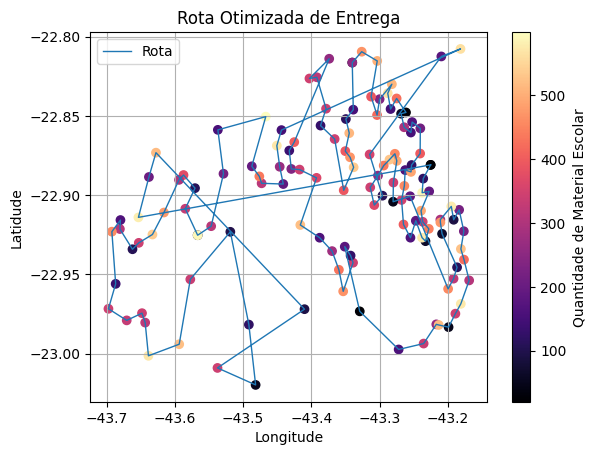

In [257]:
import matplotlib.pyplot as plt
lat = list(df_ordered['lat'])
lon = list(df_ordered['lon'])
qtd = list(df_ordered['qtd_material_didatico'])
plt.plot(lon, lat, '-', linewidth = 1)
plt.legend(['Rota','','',''])
plt.scatter(lon, lat, c = qtd, cmap = 'magma')
plt.colorbar(label = "Quantidade de Material Escolar")
plt.grid()
plt.title('Rota Otimizada de Entrega')
plt.xlabel('Longitude')
plt.ylabel('Latidude')
plt.show()

In [255]:
qtd

[20.0,
 121.0,
 591.0,
 190.0,
 491.0,
 342.0,
 445.0,
 63.0,
 576.0,
 185.0,
 164.0,
 399.0,
 350.0,
 457.0,
 158.0,
 489.0,
 123.0,
 397.0,
 210.0,
 167.0,
 153.0,
 292.0,
 61.0,
 24.0,
 426.0,
 151.0,
 564.0,
 509.0,
 234.0,
 416.0,
 393.0,
 504.0,
 468.0,
 67.0,
 257.0,
 152.0,
 115.0,
 513.0,
 395.0,
 468.0,
 534.0,
 392.0,
 342.0,
 128.0,
 342.0,
 317.0,
 345.0,
 260.0,
 400.0,
 136.0,
 235.0,
 342.0,
 362.0,
 520.0,
 161.0,
 279.0,
 430.0,
 466.0,
 342.0,
 128.0,
 179.0,
 26.0,
 159.0,
 336.0,
 262.0,
 516.0,
 48.0,
 342.0,
 573.0,
 308.0,
 420.0,
 525.0,
 223.0,
 220.0,
 92.0,
 578.0,
 293.0,
 473.0,
 67.0,
 111.0,
 319.0,
 456.0,
 183.0,
 44.0,
 342.0,
 493.0,
 456.0,
 530.0,
 440.0,
 255.0,
 342.0,
 365.0,
 109.0,
 352.0,
 180.0,
 561.0,
 148.0,
 571.0,
 269.0,
 187.0,
 315.0,
 435.0,
 194.0,
 599.0,
 157.0,
 221.0,
 316.0,
 71.0,
 591.0,
 330.0,
 109.0,
 372.0,
 296.0,
 479.0,
 537.0,
 342.0,
 106.0,
 308.0,
 162.0,
 459.0,
 135.0,
 342.0,
 329.0,
 341.0,
 320.0,
 570.0,
 52